In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/Users/kunthshah/Desktop/Crypto-Price-Moevement-Prediction/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = pd.read_csv('Dataset/crypto_price_movement_dataset.csv')
df.head()

,Date,Open_Price,Close_Price,High_Price,Low_Price,Price_Change,Volume,MA_5,MA_10,RSI,Volatility,Sentiment_Score,Global_Economy,Event_Impact,Price_Movement
0,2023-01-01,41236.203565,41583.440143,42164.219187,41514.228466,347.236578,6746503,0.000000,0.0,39.782970,0.011679,0.806251,1,0.052810,1
1,2023-01-02,58521.429192,58515.946236,59042.917886,57930.249488,-5.482956,6569064,0.000000,0.0,52.667760,0.042812,0.010386,0,0.082150,0
2,2023-01-03,51959.818254,51655.283865,52006.320815,50856.415124,-304.534389,8066677,0.000000,0.0,30.473258,0.031347,0.555665,1,0.092787,0
3,2023-01-04,47959.754526,48196.396313,48689.608970,47431.923218,236.641787,8759881,0.000000,0.0,54.708497,0.038986,-0.563440,0,0.079497,1
4,2023-01-05,34680.559213,34599.237349,34964.333984,33761.841141,-81.321864,7696906,46910.060781,0.0,30.916759,0.045281,0.242467,0,0.064309,0


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Split raw DataFrame by time (70/15/15)
n = len(df)
train_end = int(n * 0.70)
val_end   = train_end + int(n * 0.15)

train_df = df.iloc[:train_end].copy()
val_df   = df.iloc[train_end:val_end].copy()
test_df  = df.iloc[val_end:].copy()

#Save cols, except taregt in feature_cols
feature_cols = df.columns.tolist()
feature_cols.remove('Price_Movement')
feature_cols.remove('Date')

# 3. Fit scaler on TRAIN only, then transform all splits
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols]   = scaler.transform(val_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

# 4. Function to build time‑windows
def create_time_windows(df, feature_cols, window_size=10):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df[feature_cols].iloc[i-window_size:i].values)
        y.append(df['Price_Movement'].iloc[i])
    return np.array(X), np.array(y)

# 5. Create windowed datasets
window_size = 10
X_train, y_train = create_time_windows(train_df, feature_cols, window_size)
X_val,   y_val   = create_time_windows(val_df,   feature_cols, window_size)
X_test,  y_test  = create_time_windows(test_df,  feature_cols, window_size)

print("Shapes:",
      X_train.shape, y_train.shape,
      X_val.shape,   y_val.shape,
      X_test.shape,  y_test.shape)


Shapes: (34990, 10, 13) (34990,) (7490, 10, 13) (7490,) (7490, 10, 13) (7490,)


In [14]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Flatten the 3D windowed data into 2D arrays (samples, features)
X_train_temp = X_train.reshape(X_train.shape[0], -1)
X_val_temp   = X_val.reshape(X_val.shape[0], -1)
X_test_temp  = X_test.reshape(X_test.shape[0], -1)

# Initialize and train the SVM classifier
svm_model = SVC(kernel='rbf', C=1.0)
svm_model.fit(X_train_temp, y_train)

# Make predictions on train, validation, and test sets
y_train_pred = svm_model.predict(X_train_temp)
y_val_pred   = svm_model.predict(X_val_temp)
y_test_pred  = svm_model.predict(X_test_temp)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
val_acc   = accuracy_score(y_val, y_val_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print("Test Accuracy:", test_acc)

Train Accuracy: 0.7923120891683338
Validation Accuracy: 0.4987983978638184
Test Accuracy: 0.5040053404539386


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential()
# Optional: A convolutional layer to capture short-term patterns.
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                 input_shape=(window_size, len(feature_cols))))
model.add(MaxPooling1D(pool_size=2))

# Bidirectional LSTM for capturing temporal dependencies in both directions.
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=True,
                             kernel_regularizer=l2(1e-5))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=False)))
model.add(BatchNormalization())

# Fully-connected layers for additional representation learning.
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Final output layer.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC', 'accuracy'])

# Print model summary
print(model_simple.summary())

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train model with early stopping
history_simple = model_simple.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Can go higher with early stopping
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 10, 128)        │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,428 (1.62 MB)

 Trainable params: 141,057 (551.00 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 282,115 (1.08 MB)

None
Epoch 1/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 0.5059 - accuracy: 0.5047 - loss: 0.6941 - val_AUC: 0.4939 - val_accuracy: 0.4944 - val_loss: 0.6940
Epoch 2/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 0.5031 - accuracy: 0.5060 - loss: 0.6939 - val_AUC: 0.4968 - val_accuracy: 0.5015 - val_loss: 0.6938
Epoch 3/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - AUC: 0.5026 - accuracy: 0.5010 - loss: 0.6939 - val_AUC: 0.4970 - val_accuracy: 0.4931 - val_loss: 0.6939
Epoch 4/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 0.5118 - accuracy: 0.5099 - loss: 0.6934 - val_AUC: 0.4997 - val_accuracy: 0.4988 - val_loss: 0.6938
Epoch 5/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - AUC: 0.5130 - accuracy: 0.5107 - loss: 0.6933 - val_AUC: 0.5069 - val_accuracy: 0.5060 - val_loss: 0.6934
Epoch 6/50
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - AUC: 0.5140 - accuracy: 0.5095 - loss: 0.6931 - val_AUC: 0.5065 - val_accuracy: 0.5035 - val_loss: 0.6939
Epoch 7/50
547/547 ━━━━━━━━

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

        Down       0.50      0.58      0.54      3769
          Up       0.50      0.42      0.46      3721

    accuracy                           0.50      7490
   macro avg       0.50      0.50      0.50      7490
weighted avg       0.50      0.50      0.50      7490



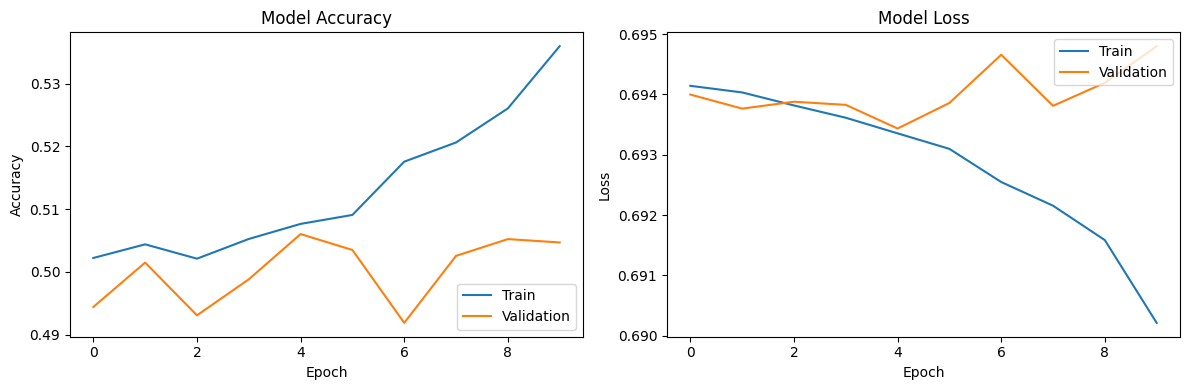

In [16]:
# Evaluate on test set
y_pred = model_simple.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=['Down', 'Up']))

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_simple.history['accuracy'])
plt.plot(history_simple.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_simple.history['loss'])
plt.plot(history_simple.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()